# Data science pour l'assurance non vie, Partie 1

## Téléchargez les packages nécessaires à la réalisation du projet

In [1]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as geopd
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, FunctionTransformer, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

from patsy import dmatrices, dmatrix

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Importer les données

In [2]:
def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)['data']
    df_freq['IDpol'] = df_freq['IDpol'].astype(int)
    df_freq.set_index('IDpol', inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)['data']

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby('IDpol').sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]
  
data = load_mtpl2(n_samples=677990)

/home/krasniqi/anaconda3/lib/python3.8/site-packages/sklearn/datasets/_openml.py:849: UserWarning: Version 1 of dataset freMTPL2freq is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://www.openml.org/data/v1/download/20649148/freMTPL2freq.arff
  warn("Version {} of dataset {} is inactive, meaning that issues have "
/home/krasniqi/anaconda3/lib/python3.8/site-packages/sklearn/datasets/_openml.py:849: UserWarning: Version 1 of dataset freMTPL2sev is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://www.openml.org/data/v1/download/20649149/freMTPL2sev.arff
  warn("Version {} of dataset {} is inactive, meaning that issues have "


## 4.3. Analyser les données

In [3]:
# Analyser la base de données (nombre de ligne, les valeurs manquantes, ...)



In [4]:
# Analyser la variable cible, indiquer la structure de cette variable



In [5]:
# Matrice de corrélation pour les variables quantitatives



## Quelques modifications de la base de données

In [6]:
# Plafoné les sinistres à 4
data["ClaimNb"] = data["ClaimNb"].clip(upper=4)

#Plafonnement l'exposition des sinistres à 1
data["Exposure"] = data["Exposure"].clip(upper=1)

#Plafonnement du Bonus-Malus à 150
data["BonusMalus_capped"]= np.clip(data.BonusMalus, None, 150)

#Plafonnement de l'âge du vehicule à 20
data["VehAge_capped"]= np.clip(data.VehAge, None, 35)

#Plafonnement de l'âge du conducteur à 85
data["DrivAge_capped"]= np.clip(data.DrivAge, None, 85)

#Mettre la densité en log
data['LogDensity'] = np.log(data['Density'])

## Créez des classes pour les variables continues afin d'aider le modèle linéaire. 

### Nous allons analyser l'âge du conducteur 

No handles with labels found to put in legend.


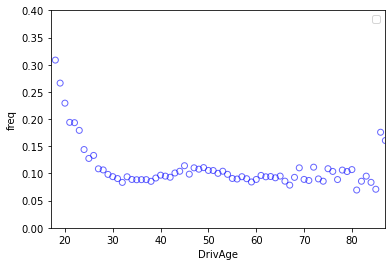

In [7]:
data_plot = data.groupby(data.DrivAge_capped).mean()
data_plot["freq_2"]=data_plot.ClaimNb/data_plot.Exposure

# Plot the splines and error bands
plt.scatter(data_plot.index, data_plot["freq_2"] , facecolor='None', edgecolor='b', alpha=0.6)
plt.legend()
plt.xlim(17,87)
plt.ylim(0,0.4)
plt.xlabel('DrivAge_capped')
plt.ylabel('freq')
plt.show()

In [8]:
'''Pour l'âge du conducteur, on crée des classes car la variable n'est pas linéaire. 
Voici les class: 18-25
                 26-35
                 36-50
                 51-70
                 71-80
                 80 et plus''' 

def drive_age_class(data):
    
    drive_age = np.array(data["DrivAge_capped"])

    new_var=[]
    for i in range(len(data)):
        
        if drive_age[i]<=25:
            new_var.append('DrivAge_0')
        elif drive_age[i]<=35 and drive_age[i]>25:
            new_var.append('DrivAge_1')
        elif drive_age[i]<=50 and drive_age[i]>35:
            new_var.append('DrivAge_2')
        elif drive_age[i]<=70 and drive_age[i]>50:
            new_var.append('DrivAge_3')
        elif drive_age[i]<=80 and drive_age[i]>70:
            new_var.append('DrivAge_4')
        else :
            new_var.append(5)
    
    data["DrivAge_class"]=new_var
    
    return data


data = drive_age_class(data)

In [ ]:
# Analyser la distribution de la variable nouvellement créée: "DrivAge_class"



### Nous allons analyser l'âge de la voiture

No handles with labels found to put in legend.


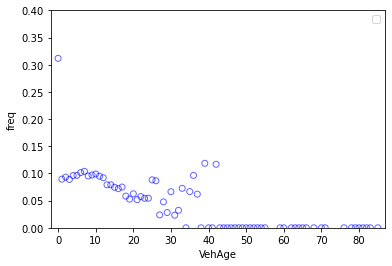

In [9]:
data_plot = data.groupby(data.VehAge).mean()
data_plot["freq_2"]=data_plot.ClaimNb/data_plot.Exposure

# Plot the splines and error bands
plt.scatter(data_plot.index, data_plot["freq_2"] , facecolor='None', edgecolor='b', alpha=0.6)
plt.legend()
plt.xlim(-2,87)
plt.ylim(0,0.4)
plt.xlabel('VehAge')
plt.ylabel('freq')
plt.show()

In [10]:
'''Pour l'âge de la voiture, on crée des classes car la variable n'est pas linéaire. 
Voici les class: ????
'''

def veh_age_class(data):
    
    VehAge = np.array(data["VehAge"])

    new_var=[]
    
    for i in range(len(data)):
        if VehAge[i]==0:
            new_var.append('VehAge_0')
        elif VehAge[i]<=5 and VehAge[i]>0:
            new_var.append('VehAge_1')
        elif VehAge[i]<=15 and VehAge[i]>5:
            new_var.append('VehAge_2')
        else :
            new_var.append('VehAge_3')
    
    data["VehAge_class"]=new_var
    
    return data

data = veh_age_class(data)

In [11]:
# Analyser la distribution de la variable nouvellement créée: "VehAge_class"


## Faire des regroupements car il y a trop de modalités dans certaines variables. 

### Nous allons nous intéresser aux marques des voitures. 

No handles with labels found to put in legend.


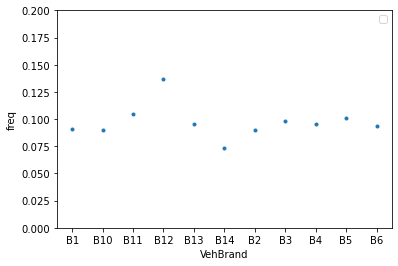

In [12]:
data_plot = data.groupby(data.VehBrand).mean()
data_plot["freq_2"]=data_plot.ClaimNb/data_plot.Exposure

plt.plot(data_plot.index, data_plot["freq_2"], '.')

plt.legend()
plt.ylim(0,0.2)
plt.xlabel('VehBrand')
plt.ylabel('freq')
plt.show()

In [13]:
# Pour marque de la voiture
def VehBrand_class(data):

    Brand = np.array(data["VehBrand"])

    VehBrand_classe = []
    for i in range(0, len(data)):
        
        if Brand[i] in ['B2', 'B4', 'B6', 'B10', 'B1']:
            VehBrand_classe.append('VehBrand_1')

        elif Brand[i] in ['B3', 'B11', 'B5', 'B13', 'B14']:
            VehBrand_classe.append('VehBrand_2')

        else:
            VehBrand_classe.append('VehBrand_3')

    data["VehBrand_class"]=VehBrand_classe
        
    return data

data = VehBrand_class(data)

No handles with labels found to put in legend.


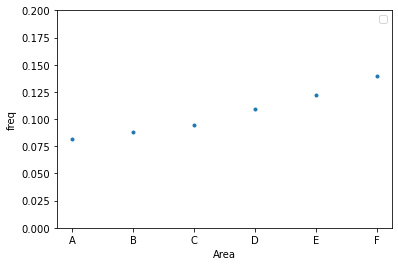

In [14]:
data_plot = data.groupby(data.Area).mean()
data_plot["freq_2"]=data_plot.ClaimNb/data_plot.Exposure

plt.plot(data_plot.index, data_plot["freq_2"], '.')

plt.legend()
plt.ylim(0,0.2)
plt.xlabel('Area')
plt.ylabel('freq')
plt.show()

In [15]:
#Pour la zone d'habitation
data['Area'] = pd.to_numeric(data['Area'].map({"A": 1, "B": 2,"C": 3,"D": 4,"E": 5,"F": 6,}))

In [45]:
#Pour la region d'habitation
gdf_france = geopd.read_file("regions-20140306-100m-shp/regions-20140306-100m.shp")
gdf_france = gdf_france[~gdf_france["nom"].isin(["Guadeloupe", "Guyane", "La Réunion", "Martinique", "Mayotte"])]
gdf_france['Region'] = "R" + gdf_france['code_insee']

<ipython-input-50-91568633918f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = (data.groupby(['Region'])['Exposure', 'ClaimNb']
<ipython-input-50-91568633918f>:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  tmp.apply(lambda x: axes[0].annotate(s=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
<ipython-input-50-91568633918f>:13: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  tmp.apply(lambda x: axes[1].annotate(s=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);


[Text(0, 40.0, ''),
 Text(0, 42.0, ''),
 Text(0, 44.0, ''),
 Text(0, 46.0, ''),
 Text(0, 48.0, ''),
 Text(0, 50.0, ''),
 Text(0, 52.0, '')]

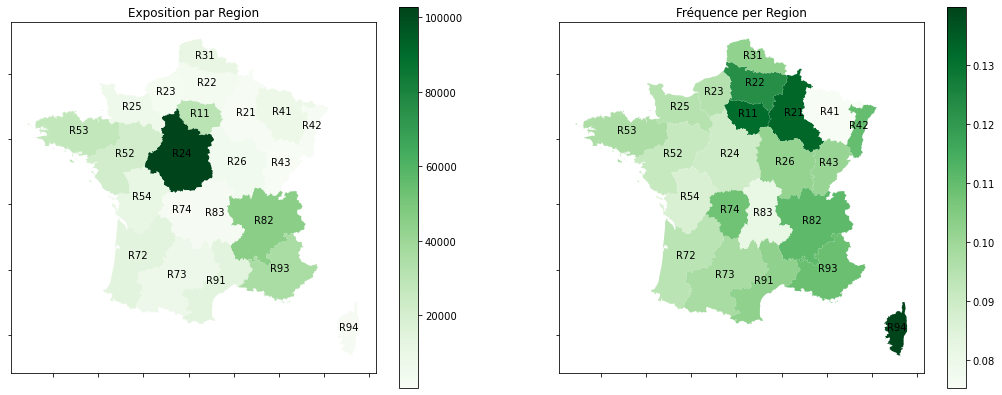

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9*2, 7))
#fig.subplots_adjust(wspace=0.5)
tmp = (data.groupby(['Region'])['Exposure', 'ClaimNb']
          .sum()
          .assign(frequency = lambda x: x['ClaimNb']/x['Exposure'])
         )
tmp = gdf_france.merge(tmp, on='Region', how='right')
tmp.plot(column='Exposure', legend=True, ax=axes[0], cmap='Greens')
tmp.plot(column='frequency', legend=True, ax=axes[1], cmap='Greens')

tmp.apply(lambda x: axes[0].annotate(s=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
tmp.apply(lambda x: axes[1].annotate(s=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
axes[0].set_title('Exposition par Region');
axes[1].set_title("Fréquence per Region");
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])

In [16]:
def Region_class(data):

    Region = np.array(data["Region"])

    Region_classe = []
    for i in range(0, len(data)):
        
        if Region[i] in ['R21', 'R94', 'R11', 'R22', 'R74']:
            Region_classe.append('C1')

        elif Region[i] in ['R91', 'R82', 'R42']:
            Region_classe.append('C2')

        elif Region[i] in ['R93', 'R53']:
            Region_classe.append('C3')

        elif Region[i] in ['R26', 'R25', 'R52', 'R31', 'R54', 'R73', 
                                'R23', 'R72', 'R83', 'R41', 'R43', 'R24']:
            Region_classe.append('C4')

    data["Region_class"]=Region_classe
        
    return data

data = Region_class(data)

### Nous allons séparer notre base de données en une base de données d'entrainement et une base de données de test avec la fonction train_test_split  

le test_size=0.2 et random_state=42

In [17]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

### Nous allons crée deux fonction pour juger de la qualité de nos modèles

* $$GLM Poisson \rightarrow \mathcal{D} = 2* \frac{1}{n}\sum_{i=1}^{n}\left(y_i\log\left(\frac{y_i}{\mu_i} \right)  -(y_i-\mu_i) \right)$$


* $$\sum_{i \in training} t_i y_i = \sum_{i \in training} t_i \hat{\mu}_i$$

In [18]:
# Function Deviance de Poisson
def PD_function(pred, obs):
    PD = 200*( sum(pred) - sum(obs) + sum( np.log( (obs/pred)**(obs) ) ) )
    return PD/len(pred)

# Function PD2: Print Poisson Deviance learn/test
def PD2_function(txt, l_c, l_x, t_c, t_x):
    print("{:s}, Train/test: {:.4f} / {:.4f}".format(txt, PD_function(l_c, l_x), PD_function(t_c, t_x)))
    
    
def diff_function(pred, obs):
    return np.round(sum(pred)-sum(obs), 4)

In [19]:
#Création d'un dataframe pour enregistrer les résultats du test, du train et pour l'AIC. 

data_results_train = pd.DataFrame()
data_results_test = pd.DataFrame()
data_aic = dict()

# Modélisation

## Modèle homogène

Notre premier modèle est le plus simple, c'est-à-dire que nous allons donner la même fréquence d'accident à tout le monde. Pour ce faire, nous allons régresser uniquement sur l'intercept. 

In [20]:
GLM_poisson_homogene = smf.glm("ClaimNb ~ 1",
                               data=X_train, 
                               exposure=np.asarray(X_train['Exposure']),
                               family=sm.families.Poisson(sm.genmod.families.links.log())
                              ).fit()
print(GLM_poisson_homogene.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542392
Model:                            GLM   Df Residuals:                   542391
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1741e+05
Date:                Wed, 05 Oct 2022   Deviance:                   1.7932e+05
Time:                        22:03:27   Pearson chi2:                 1.53e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2959      0.006   -390.091      0.0

In [21]:
print("La fréquence des accidents est: ", np.exp(GLM_poisson_homogene.params[0]))

La fréquence des accidents est:  0.10067246532855481


### Les résultats doivent être enregistrés dans les dataframes.

In [22]:
data_results_test['Homogene'] = GLM_poisson_homogene.predict(X_test[['Exposure']])* X_test["Exposure"]
data_results_train['Homogene'] = GLM_poisson_homogene.predict(X_train[['Exposure']])* X_train["Exposure"]

PD2_function("La déviance de Poisson pour le Modele Homogène est ", 
             data_results_train['Homogene'], X_train["ClaimNb"], 
             data_results_test['Homogene'], X_test["ClaimNb"])

print('\n')
print("{:s}: {:.4f}".format("L'aic est de", GLM_poisson_homogene.aic)) 
data_aic['Homogene'] = GLM_poisson_homogene.aic

print('\n')
print('la différence test', sum(data_results_test['Homogene']), sum(X_test["ClaimNb"]))
print('la différence train', sum(data_results_train['Homogene']), sum(X_train["ClaimNb"]))

La déviance de Poisson pour le Modele Homogène est , Train/test: 33.0603 / 32.9031


L'aic est de: 234818.6997


la différence test 7207.98288068923 7187.0
la différence train 28868.99999996791 28869.0


# Modèle avec plusieurs variables de régression 

Pour réaliser cette exercice, il faut utiliser dmatrices. Voici un exemple:

formule = "ClaimNb ~ C(DrivAge_class)"

response, predictors_train = dmatrices(formule, X_train, return_type='dataframe')

Glm_Divers = sm.GLM(response_train, predictors_train,
              exposure=np.asarray(X_train.Exposure),
              family=sm.families.Poisson(sm.genmod.families.links.log())).fit()

print(Glm_Divers.summary())


S'il y a une variable catégorielle, vous devez ajouter un C et mettre la variable entre parenthèses. La fonction dmatrices va créer automatiquement la base de données en effectuant directement l'auto-codage pour les variables catégorielles. 

In [25]:
formule = "ClaimNb ~ C(Area) + VehPower + LogDensity + C(DrivAge_class) + C(VehAge_class)"

response_train, predictors_train = dmatrices(formule, X_train, return_type='dataframe')
response_test, predictors_test = dmatrices(formule, X_test, return_type='dataframe')

Glm_Divers = sm.GLM(response_train, predictors_train,
              exposure=np.asarray(X_train.Exposure),
              family=sm.families.Poisson(sm.genmod.families.links.log())).fit()

print(Glm_Divers.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542392
Model:                            GLM   Df Residuals:                   542376
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1465e+05
Date:                Wed, 05 Oct 2022   Deviance:                   1.7380e+05
Time:                        22:11:26   Pearson chi2:                 1.24e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

### Les résultats doivent être enregistrés dans les dataframes.

In [26]:
data_results_test['divers'] = Glm_Divers.predict(predictors_test)* X_test["Exposure"]
data_results_train['divers'] = Glm_Divers.predict(predictors_train)* X_train["Exposure"]

PD2_function("La déviance de Poisson pour le Modele est ", 
             data_results_train['divers'], X_train["ClaimNb"], 
             data_results_test['divers'], X_test["ClaimNb"])

print("{:s}: {:.4f}".format("L'aic est de", Glm_Divers.aic)) 
data_aic['divers'] = Glm_Divers.aic

print('\n')
print('la différence test', sum(data_results_test['divers']), sum(X_test["ClaimNb"]))
print('la différence train', sum(data_results_train['divers']), sum(X_train["ClaimNb"]))

La déviance de Poisson pour le Modele est , Train/test: 32.0431 / 32.0145
L'aic est de: 229331.6730


la différence test 7183.480736516782 7187.0
la différence train 28868.99999999959 28869.0


### Qu'est-ce qui se passe avec la déviance de Poisson et l'AIC ? 

Réponse:

## 5.3. Modèle avec plusieurs variables de régression et une étape de sélection des variables

Comme il est extrêmement difficile de calibrer le modèle à la main, nous procéderons par étapes. Nous coderons une méthode par étapes pour sélectionner les variables les plus pertinentes. 

In [23]:
def stepwise_reg(data_train, candidat):
    
    save_model = []

    GLM_select = smf.glm("ClaimNb ~ 1",
                         data=data_train,
                         exposure=np.asarray(data_train['Exposure']),
                         family=sm.families.Poisson(sm.genmod.families.links.log())).fit()

    score_aic = GLM_select.aic
    iteration=0

    while len(candidat)>0:

        #stacker les resultats
        save_result = pd.DataFrame(columns=['candidat','aic'])
        print("l'aic de référence est :", score_aic)
        #print('les variables candidates pour le modèle sont :', candidat)

        for c in candidat:

            iteration = iteration+1

            model = ' + '.join(save_model + [c])
            
            formula = """ClaimNb ~ """ + model

            response, predictors = dmatrices(formula, data_train, return_type='dataframe')

            GLM_select = sm.GLM(response, predictors, exposure=np.asarray(data_train['Exposure']),
                                family=sm.families.Poisson(sm.genmod.families.links.log())).fit()

            print("iter: "+str(iteration)+", candidat: "+str(c)+", aic: "+str(GLM_select.aic))

            save_result = save_result.append({'candidat':c, 'aic':GLM_select.aic}, ignore_index=True)

        index = save_result['aic'].idxmin()

        if score_aic<save_result['aic'][index]:

            print('breakkkkkkkkk')

            break

        else:
            score_aic=save_result['aic'][index]

        save_model.append(save_result['candidat'][index])
        print('\n')
        print('la meilleure variable est: '+ str(save_result['candidat'][index]))
        print('avec un aic de: ' + str(save_result['aic'][index]))
        print('\n')
        candidat.remove(save_result['candidat'][index])                  

    print("le meilleur modele est :", save_model)
    
    return save_model

In [27]:
#Sélectionner les meilleures variables 
candidat = ["C(Area)", "VehPower","LogDensity", "C(DrivAge_class)", "C(VehAge_class)",
            "C(VehBrand_class)", "Area", "C(Region_class)", "BonusMalus_capped"]

best_var = stepwise_reg(X_train, candidat)

l'aic de référence est : 234818.699737965
iter: 1, candidat: C(Area), aic: 234186.58932588075
iter: 2, candidat: VehPower, aic: 234813.33953672132
iter: 3, candidat: LogDensity, aic: 234160.3492894956
iter: 4, candidat: C(DrivAge_class), aic: 234226.13978488048
iter: 5, candidat: C(VehAge_class), aic: 230374.41010617875
iter: 6, candidat: C(VehBrand_class), aic: 233992.3424474238
iter: 7, candidat: Area, aic: 234192.54578898908
iter: 8, candidat: C(Region_class), aic: 234394.33239946864
iter: 9, candidat: BonusMalus_capped, aic: 231341.60679374213


la meilleure variable est: C(VehAge_class)
avec un aic de: 230374.41010617875


l'aic de référence est : 230374.41010617875
iter: 10, candidat: C(Area), aic: 229969.50230739414
iter: 11, candidat: VehPower, aic: 230375.95170664403
iter: 12, candidat: LogDensity, aic: 229949.82087873266
iter: 13, candidat: C(DrivAge_class), aic: 229743.03090118314
iter: 14, candidat: C(VehBrand_class), aic: 230255.61897638507
iter: 15, candidat: Area, aic: 2

In [28]:
#Utiliser les meilleures variables pour construire un nouveau modèle. 
model = ' + '.join(best_var)

formula = """ClaimNb ~ """ + model
response_train, predictors_train  = dmatrices(formula, X_train, return_type='dataframe')
response_test, predictors_test = dmatrices(formula, X_test, return_type='dataframe')

GLM_step_wise = sm.GLM(response_train, predictors_train, exposure=np.asarray(X_train['Exposure']),
                                    family=sm.families.Poisson(sm.genmod.families.links.log())).fit()

In [31]:
print(GLM_step_wise.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542392
Model:                            GLM   Df Residuals:                   542375
Model Family:                 Poisson   Df Model:                           16
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1308e+05
Date:                Wed, 05 Oct 2022   Deviance:                   1.7065e+05
Time:                        22:16:55   Pearson chi2:                 1.22e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [29]:
data_results_test['step_wise'] = GLM_step_wise.predict(predictors_test)* X_test["Exposure"]
data_results_train['step_wise'] = GLM_step_wise.predict(predictors_train)* X_train["Exposure"]

PD2_function("La déviance de Poisson pour le Modele stepwise est ", 
             data_results_train['step_wise'], X_train["ClaimNb"], 
             data_results_test['step_wise'], X_test["ClaimNb"])

print('\n')
print("{:s}: {:.4f}".format("L'aic est de", GLM_step_wise.aic)) 
data_aic['step_wise'] = GLM_step_wise.aic


print('\n')
print('la différence test', sum(data_results_test['step_wise']), sum(X_test["ClaimNb"]))
print('la différence train', sum(data_results_train['step_wise']), sum(X_train["ClaimNb"]))

La déviance de Poisson pour le Modele stepwise est , Train/test: 31.4627 / 31.4383


L'aic est de: 226185.5634


la différence test 7183.692905512151 7187.0
la différence train 28869.000000000957 28869.0


# Generalized Additive Model (GAM)

Prenons l'exemple de l'âge du conducteur. Dans la section précédente, nous avons discrétisé cette variable mais nous pourrions faire mieux en utilisant des splines.

In [32]:
#df=11 c'est le nombre de degré de liberté, il peut etre selectionné avec une cross validation
transformed_DrivAge = dmatrix("cr(X_train.DrivAge_capped, df = 7)", 
                         {"train": X_train.DrivAge_capped}, 
                         return_type='dataframe')

GAM_DrivAge = sm.GLM(X_train.ClaimNb, transformed_DrivAge,
              exposure=np.asarray(X_train.Exposure),
              family=sm.families.Poisson(sm.genmod.families.links.log())).fit()

print(GAM_DrivAge.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542392
Model:                            GLM   Df Residuals:                   542385
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1696e+05
Date:                Wed, 05 Oct 2022   Deviance:                   1.7843e+05
Time:                        22:17:45   Pearson chi2:                 1.52e+06
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

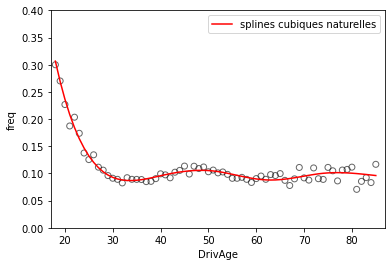

In [33]:
Mat = X_train.groupby(X_train.DrivAge_capped).mean()
Mat["freq_2"]=Mat.ClaimNb/Mat.Exposure
pred1 = GAM_DrivAge.predict(dmatrix("cr(age_grid, df = 7)", 
                             {"age_grid": Mat.index}, return_type='dataframe'))

# Plot the splines and error bands
plt.scatter(Mat.index, Mat["freq_2"] , facecolor='None', edgecolor='k', alpha=0.6)
plt.plot(Mat.index, pred1, color='r', label='splines cubiques naturelles')
plt.legend()
plt.xlim(17,87)
plt.ylim(0,0.4)
plt.xlabel('DrivAge')
plt.ylabel('freq')
plt.show()

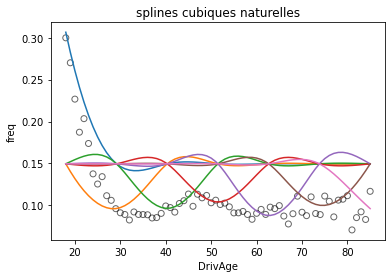

In [34]:
x = Mat.index
y = dmatrix("cr(x, df = 7) - 1", {"x": x})
b=np.array(GAM_DrivAge.params[1:])
plt.title("splines cubiques naturelles");
plt.scatter(Mat.index, Mat["freq_2"] , facecolor='None', edgecolor='k', alpha=0.6)
plt.plot(Mat.index, np.exp(np.array(GAM_DrivAge.params[0]))*np.exp(y*b))
plt.xlabel('DrivAge')
plt.ylabel('freq')
plt.show()

## C'est à vous de jouer pour la variable âge de la voiture.

In [35]:
## GAM âge de la voiture
## # A vous de jouer 

## Etape de sélection des variables avec les splines

Nous allons faire la même chose que précédemment mais cette fois-ci nous allons rajouter la variable d'âge que nous avons construite avec les splines.

In [36]:
#Sélectionner les meilleures variables 
candidat_spline = ["C(Area)", "VehPower","LogDensity", "cr(DrivAge_capped, df = 7)", "C(VehAge_class)",
            "C(VehBrand_class)", "Area", "C(Region_class)", "BonusMalus_capped"]

best_var_spline = stepwise_reg(X_train, candidat_spline)

l'aic de référence est : 234818.699737965
iter: 1, candidat: C(Area), aic: 234186.58932588075
iter: 2, candidat: VehPower, aic: 234813.33953672132
iter: 3, candidat: LogDensity, aic: 234160.3492894956
iter: 4, candidat: cr(DrivAge_capped, df = 7), aic: 233941.83884864667
iter: 5, candidat: C(VehAge_class), aic: 230374.41010617875
iter: 6, candidat: C(VehBrand_class), aic: 233992.3424474238
iter: 7, candidat: Area, aic: 234192.54578898908
iter: 8, candidat: C(Region_class), aic: 234394.33239946864
iter: 9, candidat: BonusMalus_capped, aic: 231341.60679374213


la meilleure variable est: C(VehAge_class)
avec un aic de: 230374.41010617875


l'aic de référence est : 230374.41010617875
iter: 10, candidat: C(Area), aic: 229969.50230739414
iter: 11, candidat: VehPower, aic: 230375.95170664403
iter: 12, candidat: LogDensity, aic: 229949.82087873266
iter: 13, candidat: cr(DrivAge_capped, df = 7), aic: 229422.04559378853
iter: 14, candidat: C(VehBrand_class), aic: 230255.61897638507
iter: 15, ca

In [37]:
#Utiliser les meilleures variables pour construire un nouveau modèle. 
var_spline = ' + '.join(best_var_spline)

formula = """ClaimNb ~ """ + var_spline
response_train, predictors_train  = dmatrices(formula, X_train, return_type='dataframe')
response_test, predictors_test = dmatrices(formula, X_test, return_type='dataframe')

GLM_step_wise_spline = sm.GLM(response_train, predictors_train, exposure=np.asarray(X_train['Exposure']),
                                    family=sm.families.Poisson(sm.genmod.families.links.log())).fit()

print(GLM_step_wise_spline.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542392
Model:                            GLM   Df Residuals:                   542374
Model Family:                 Poisson   Df Model:                           17
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1295e+05
Date:                Wed, 05 Oct 2022   Deviance:                   1.7039e+05
Time:                        22:20:42   Pearson chi2:                 1.22e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [38]:
data_results_test['step_wise_spline'] = GLM_step_wise_spline.predict(predictors_test)* X_test["Exposure"]
data_results_train['step_wise_spline'] = GLM_step_wise_spline.predict(predictors_train)* X_train["Exposure"]

PD2_function("La déviance de Poisson pour le Modele stepwise avec spline est ", 
             data_results_train['step_wise_spline'], X_train["ClaimNb"], 
             data_results_test['step_wise_spline'], X_test["ClaimNb"])

print('\n')
print("{:s}: {:.4f}".format("L'aic est de", GLM_step_wise_spline.aic)) 
data_aic['step_wise_spline'] = GLM_step_wise_spline.aic

print('\n')
print('la différence test', sum(data_results_test['step_wise_spline']), sum(X_test["ClaimNb"]))
print('la différence train', sum(data_results_train['step_wise_spline']), sum(X_train["ClaimNb"]))

La déviance de Poisson pour le Modele stepwise avec spline est , Train/test: 31.4145 / 31.4088


L'aic est de: 225926.2493


la différence test 7181.38480454743 7187.0
la différence train 28868.999999999214 28869.0


# Résumé

In [39]:
for i in data_results_test.columns:
    print(i)
    print("- Pour le Modele "+str(i)+" :")
    PD2_function("La déviance de Poisson est ", 
             data_results_train[i], X_train["ClaimNb"], 
             data_results_test[i], X_test["ClaimNb"])
    
    print("- l'aic est de " +str(data_aic[i]))
    print('- la différence test', sum(data_results_test[i]), sum(X_test["ClaimNb"]))
    print('- la différence train', sum(data_results_train[i]), sum(X_train["ClaimNb"]))
    print('\n')

Homogene
- Pour le Modele Homogene :
La déviance de Poisson est , Train/test: 33.0603 / 32.9031
- l'aic est de 234818.699737965
- la différence test 7207.98288068923 7187.0
- la différence train 28868.99999996791 28869.0


divers
- Pour le Modele divers :
La déviance de Poisson est , Train/test: 32.0431 / 32.0145
- l'aic est de 229331.67296445335
- la différence test 7183.480736516782 7187.0
- la différence train 28868.99999999959 28869.0


step_wise
- Pour le Modele step_wise :
La déviance de Poisson est , Train/test: 31.4627 / 31.4383
- l'aic est de 226185.56335111434
- la différence test 7183.692905512151 7187.0
- la différence train 28869.000000000957 28869.0


step_wise_spline
- Pour le Modele step_wise_spline :
La déviance de Poisson est , Train/test: 31.4145 / 31.4088
- l'aic est de 225926.24925624285
- la différence test 7181.38480454743 7187.0
- la différence train 28868.999999999214 28869.0


